# Week6 Water Quality Predicition by KNN

## 1.Introduction



In this week's project, I plan to utilize the `K-Nearest Neighbors (KNN) model` for water quality classification. The project primarily consists of data preprocessing and analysis, model training.

Due to factors like geographical, water quality varies across different countries. For example, a relatively common phenomenon is that many Asian students studying in the UK tend to use shower filters to prevent hair loss, as the water in the UK is relatively hard and may not be suitable for their body. Similarly, while tap water in the UK meets the standards for direct consumption, many people in China prefer not to drink tap water directly. These phenomena resulting from differences in water quality sparked my interest, leading me to choose a dataset related to water quality for further research.

Similar with my previous week's project，During the `data preprocessing and analysis` phase, I will handle missing values, analyze the distribution of features, and provide an overview of the discrete distribution of water quality labels to gain a deeper understanding of the dataset.

In the model training phase, I will incorporate `Principal Component Analysis (PCA)` and `GridSearchCV` to optimize the performance of the KNN model. Specifically, I will analyze and compare the classification performance across different values of K, identify the optimal K value, and visualize the decision boundary to observe the model’s decision patterns.

Furthermore, after completing the model training, I will employ evaluation tools such as the `Confusion Matrix` to conduct an in-depth analysis of the model’s performance.

In [31]:
# !pip install lightgbm

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning imports
import lightgbm as lgbm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

## 2. Data Preprocess And Analysis

First, I conducted an overview of the dataset, examining its features, data types, and several rows among it.

In [2]:
df = pd.read_csv(r'../Datasets\water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Through the above observations, I found:

* `Potability` of water is influenced by 9 features, all of which are of the `float` data type and represent numerical values.

* Some columns contain missing values that require preprocessing.

I further examined the statistics of the float-type features using `.describe()`, revealing significant differences in their value ranges. For instance, the `ph` column ranges from 0 to 14, whereas the `Conductivity` column spans from 181.48 to 753.34.

Since `KNN` relies on distance-based calculations, such disparities in feature scales may disproportionately affect distance measurements. Therefore, `StandardScaler` will need to be applied in the subsequent preprocessing steps. 

In [5]:
df.describe().round(2)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.00,3276.00,3276.00,3276.00,2495.00,3276.00,3276.00,3114.00,3276.00,3276.00
mean,7.08,196.37,22014.09,7.12,333.78,426.21,14.28,66.40,3.97,0.39
std,1.59,32.88,8768.57,1.58,41.42,80.82,3.31,16.18,0.78,0.49
min,0.00,47.43,320.94,0.35,129.00,181.48,2.20,0.74,1.45,0.00
25%,6.09,176.85,15666.69,6.13,307.70,365.73,12.07,55.84,3.44,0.00
50%,7.04,196.97,20927.83,7.13,333.07,421.88,14.22,66.62,3.96,0.00
75%,8.06,216.67,27332.76,8.11,359.95,481.79,16.56,77.34,4.50,1.00
max,14.00,323.12,61227.20,13.13,481.03,753.34,28.30,124.00,6.74,1.00


Next, I obsearved the count and distribution of unique values in the `Potability` column.

In [6]:
df["Potability"].value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

Potability
0    1998
1    1278
Name: count, dtype: int64


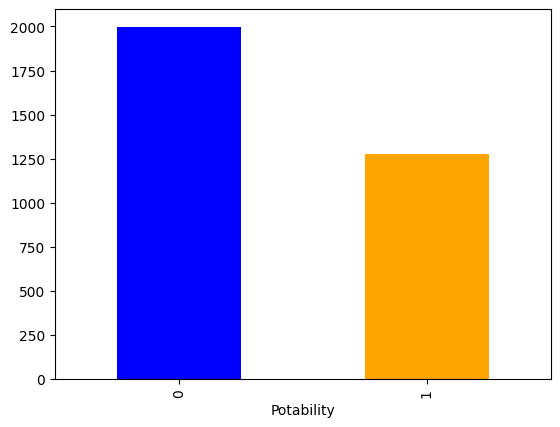

In [7]:
print(df.Potability.value_counts())
p=df.Potability.value_counts().plot(kind="bar",color=["blue", "orange"])

* The `Potability` column contains only two discrete values, representing whether the water is safe or unsafe for consumption. This aligns with the Bernoulli distribution.

* The number of unsafe water samples is significantly higher than that of safe water samples

Next, I will handle the missing value in the dataset.

In [8]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

The ph, Sulfate, and Trihalomethanes columns contain missing values, and I chose the appropriate strategy based on the distribution characteristics of each feature to handle these missing values.

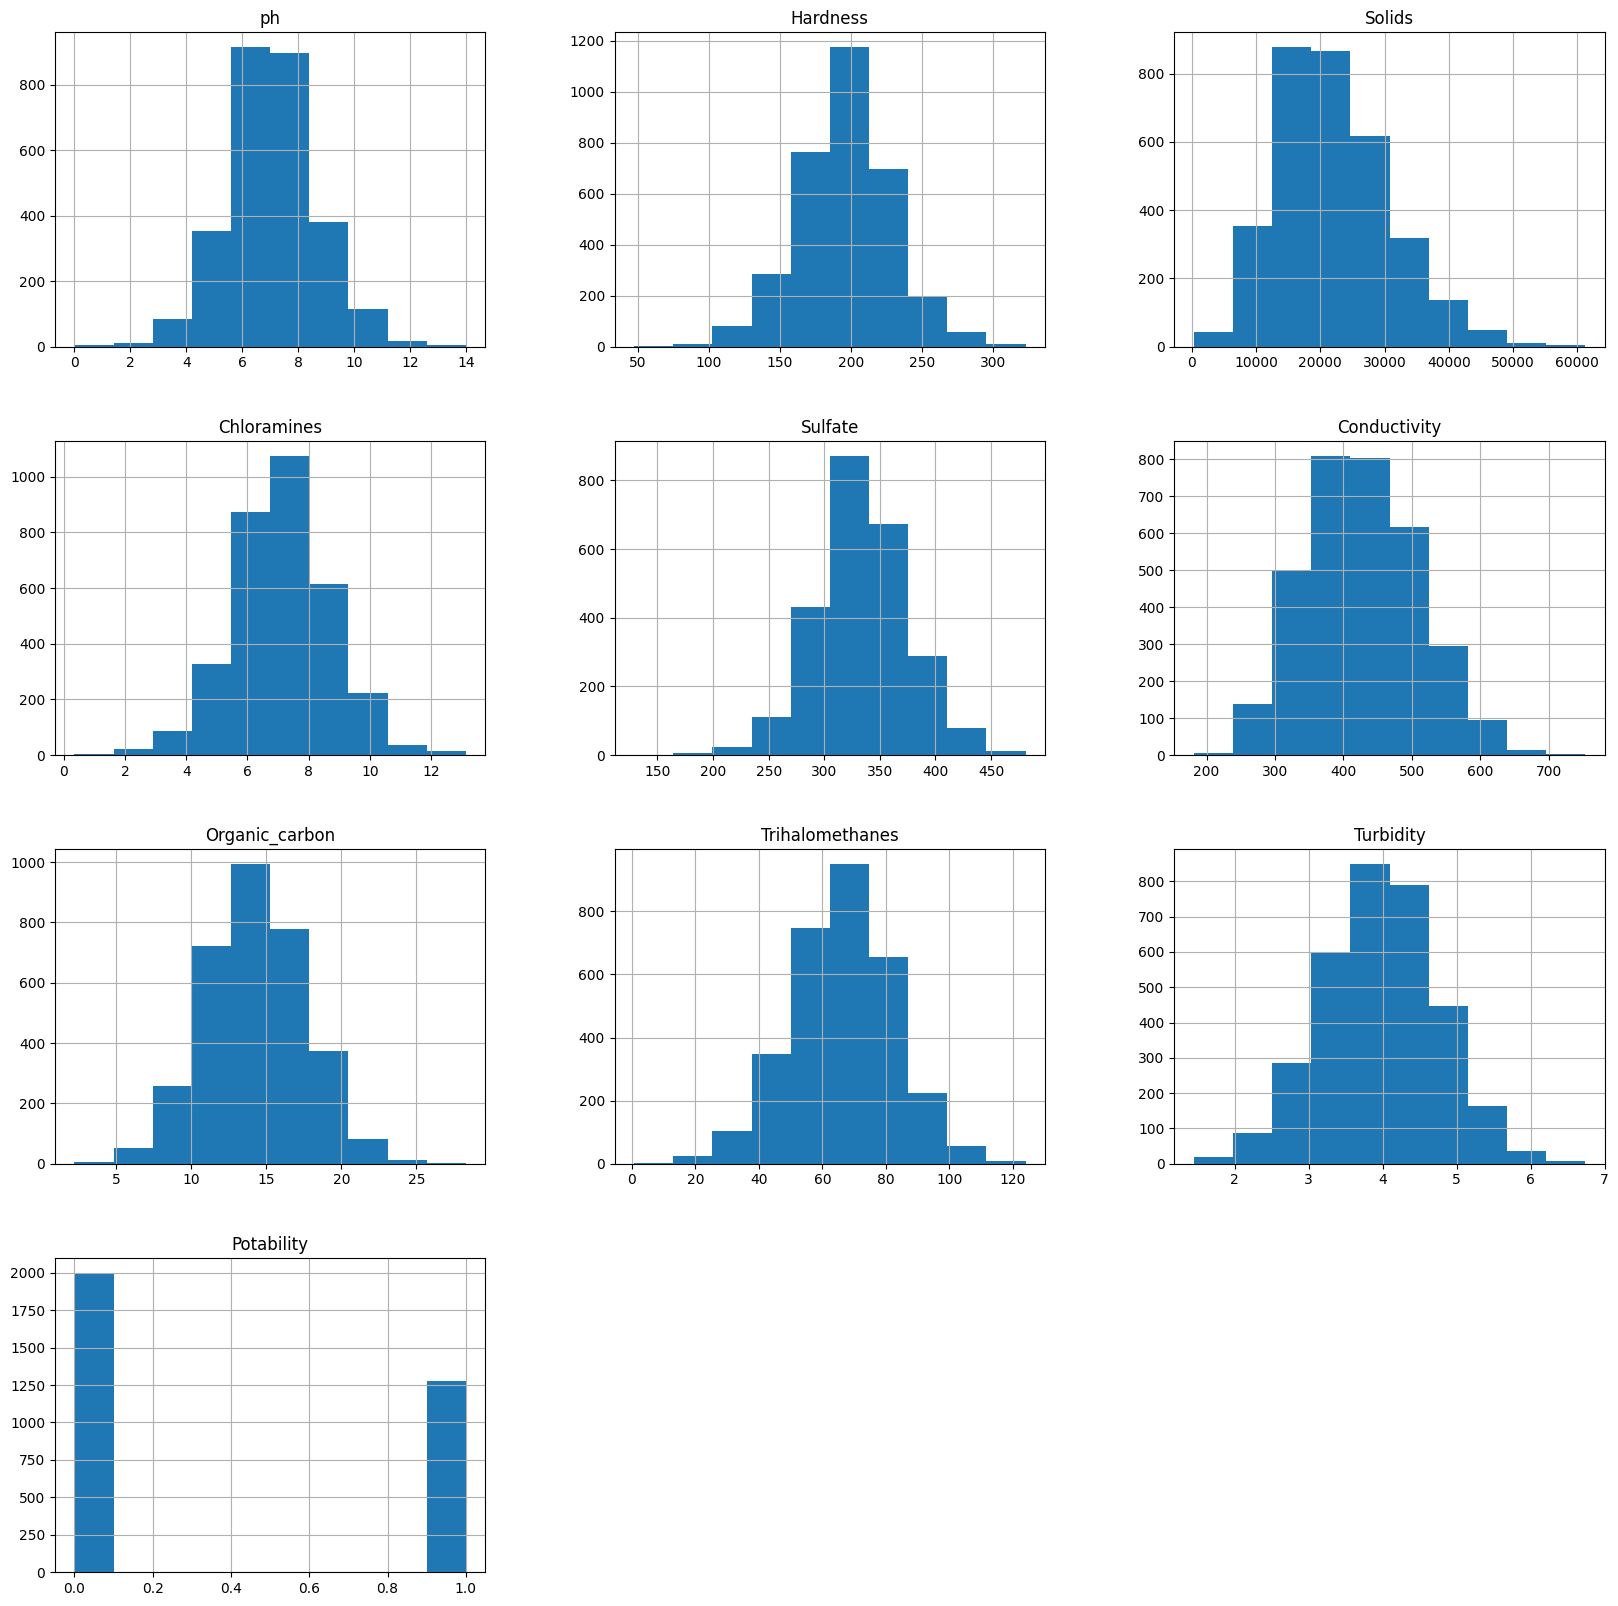

In [9]:
# How to fill these NaN value
# Based on distribution of uncleaned data

p = df.hist(figsize = (20,20))

I observed that most features in the dataset, including the three mentioned columns, approximately follow a `normal distribution`.

When data is normally distributed, the `mean` serves as a good representation of the central tendency. Therefore, I chose to impute missing values using the `mean` for these features.

In my extracurricular studies, I also learned that when a dataset contains a significant number of outliers, using the median for imputation can be a more robust approach, as the median is less sensitive to extreme values and provides a more stable estimate of the typical value.

In [10]:
df.fillna({
    'ph': df['ph'].mean(),
    'Sulfate': df['Sulfate'].mean(),
    'Trihalomethanes': df['Trihalomethanes'].mean()
}, inplace=True)
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

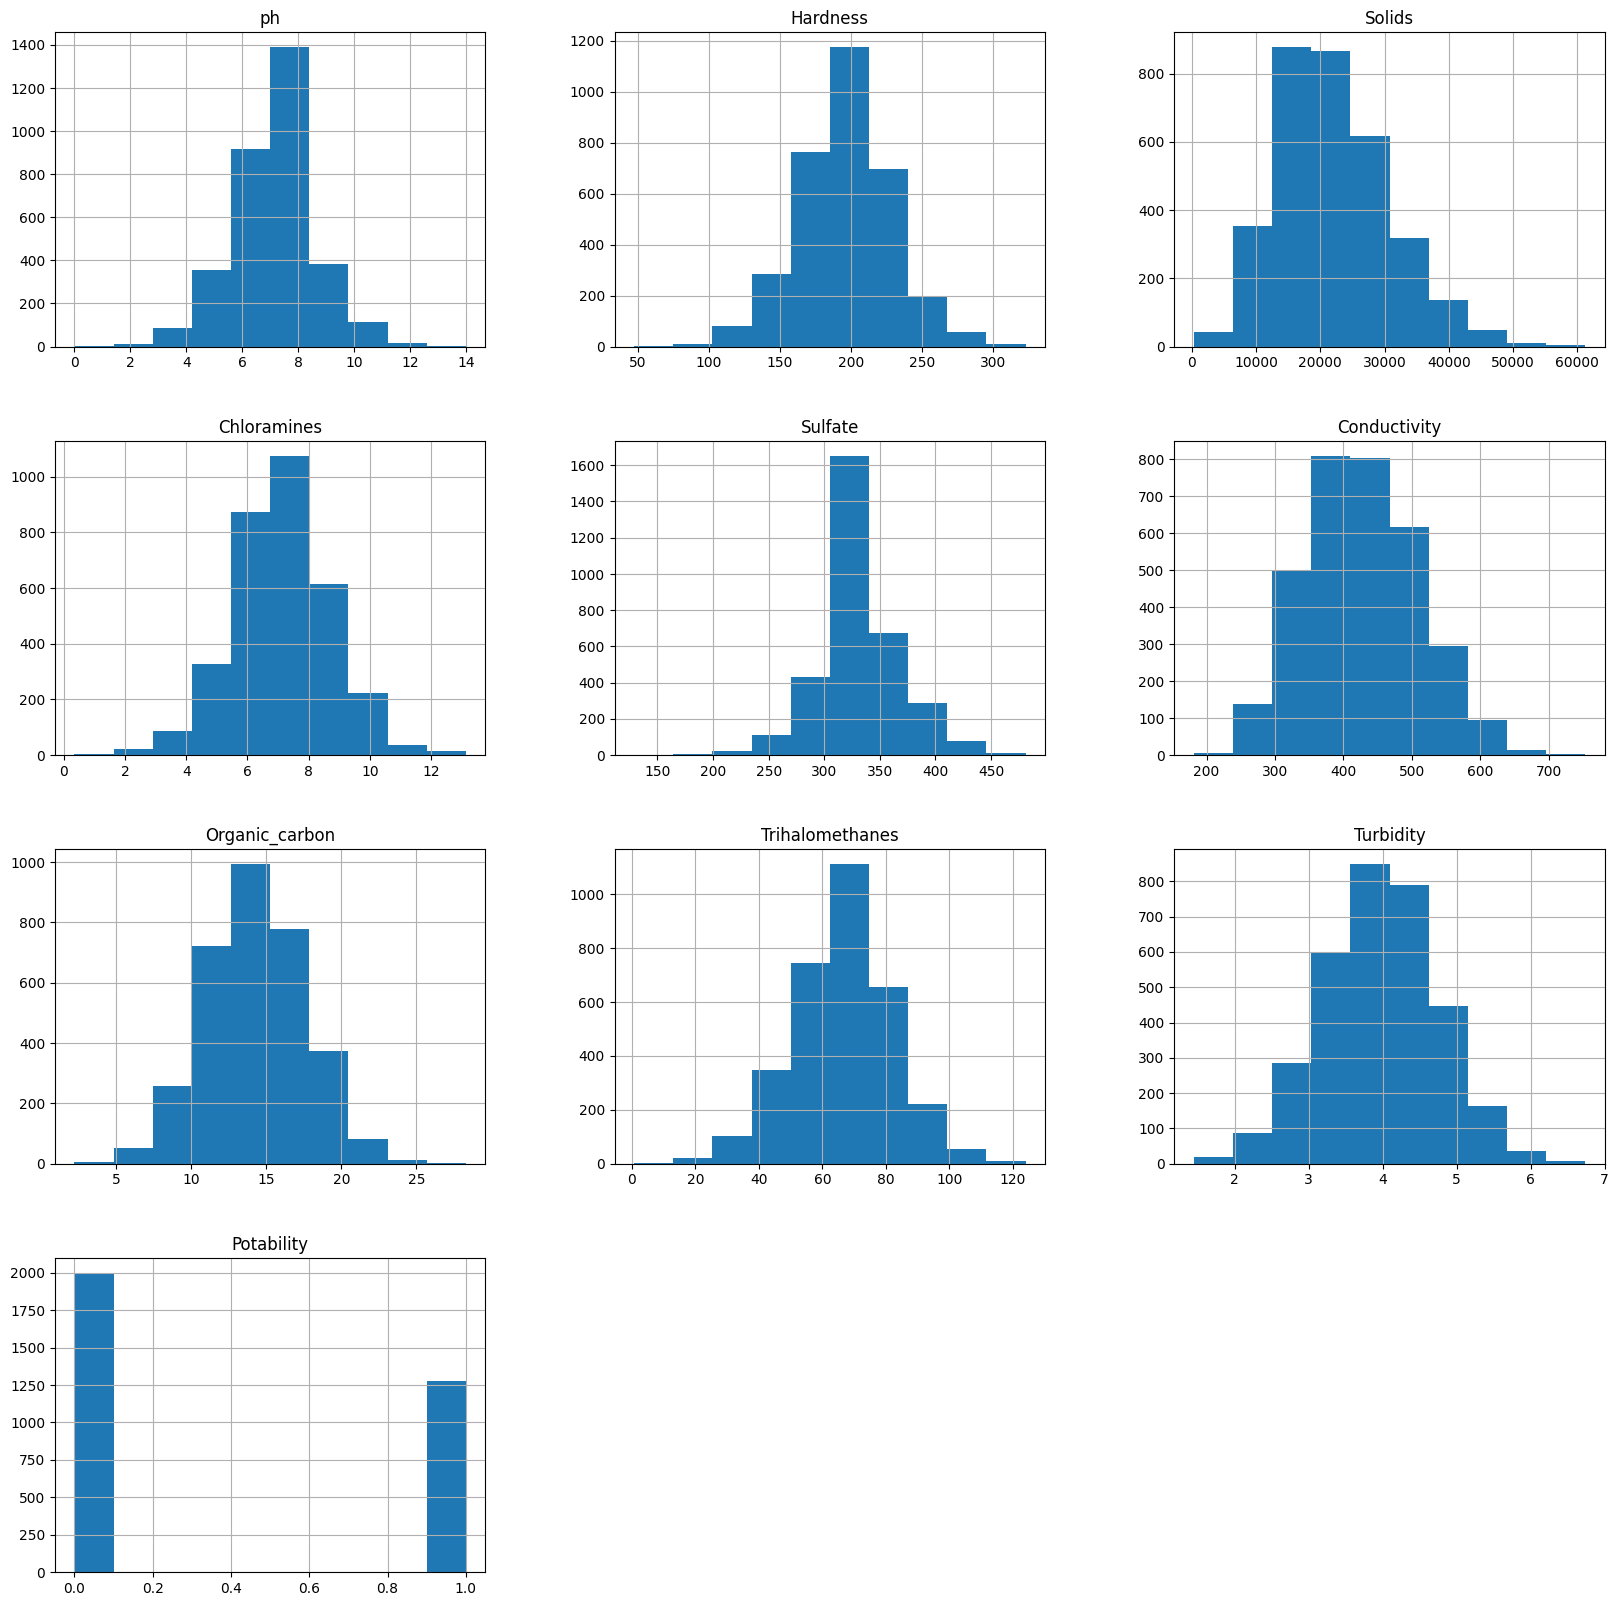

In [11]:
p = df.hist(figsize = (20,20))

When exploring the `correlation` between `Potability` and other features, I attempted to visualize the data using Seaborn’s `heatmap`.

This is a commonly used visualization technique for representing correlation matrices, allowing for an intuitive understanding of relationships between variables.

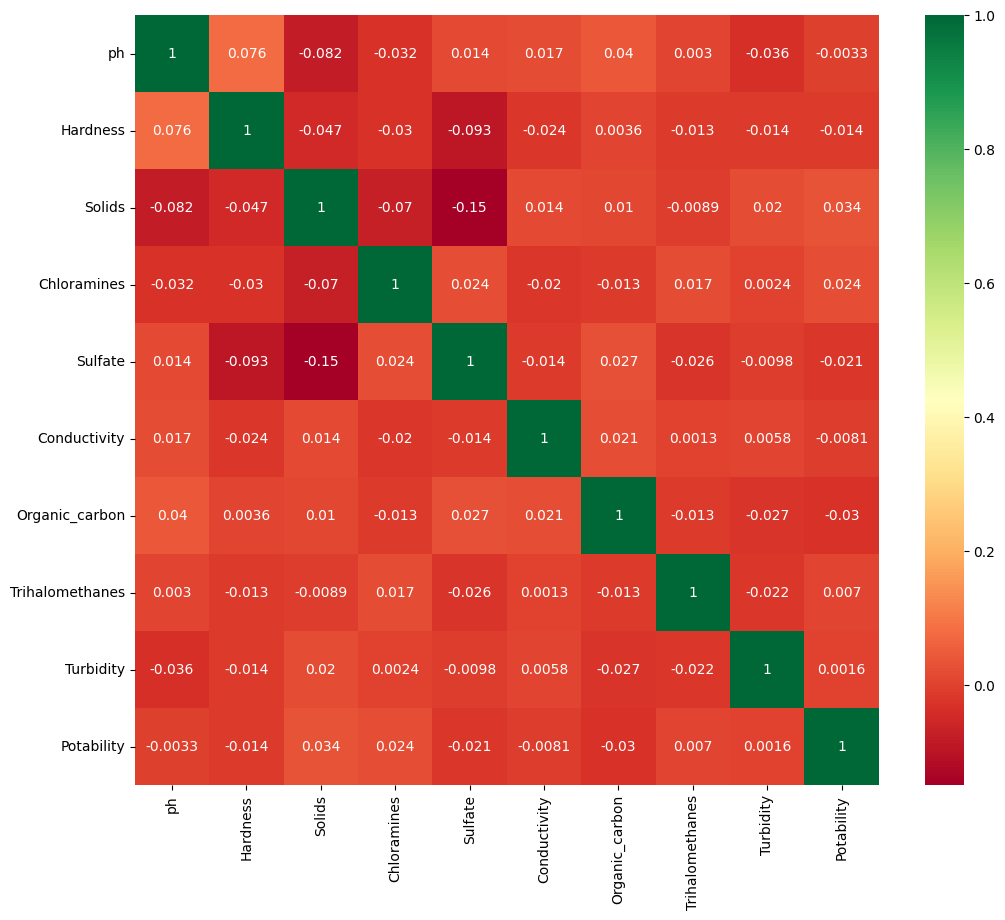

In [12]:
plt.figure(figsize=(12,10))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')

Observing the `heatmap`, I found that: 

* The correlation between `Potability` and nearly all features is very weak. This may significantly impact the performance of the subsequent model training.

* In cases where there are many features but low correlation, one suitable approach is to apply `Principal Component Analysis (PCA)` for dimensionality reduction, based on my current knowledge.

## 3. Water Potability Prediction

For the reasons mentioned above, I standardized the features to ensure a consistent scale across all variables.

In [13]:
x = df.drop("Potability", axis=1)
y = df["Potability"]
scaler = StandardScaler()
x = scaler.fit_transform(x)

# data.head()

Next, I applied PCA for dimensionality reduction and experimented with different values of `n_components` to evaluate their impact on model prediction accuracy.

Additionally, I split the dataset into training and testing sets.

In [14]:
# Futher exploration - PCA
from sklearn.decomposition import PCA
num_dimensions = 2
pca = PCA(n_components = num_dimensions)
x_pca = pca.fit_transform(x)
# x_pca

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x_pca,y,test_size = 0.2, random_state = 0,stratify=y)

In the following `for loop`, I iterated through a predefined range of K values to identify the optimal K that yields the highest accuracy (by retrieving the index of the maximum test score). Additionally, I stored all `train_scores` and `test_scores` for subsequent visualization.

By plotting these scores together, I can analyze the model’s performance across different K values, assess its fitting behavior, and identify the optimal K. 

In [16]:
test_scores = []
train_scores = []

for i in range(1,30):

    knn = KNeighborsClassifier(i)
    knn.fit(x_train,y_train)

    train_scores.append(knn.score(x_train,y_train))
    test_scores.append(knn.score(x_test,y_test))

max_test_score = max(test_scores)
test_scores_ind = [i + 1 for i, v in enumerate(test_scores) if v == max_test_score]

print(f"Max test score: {max_test_score * 100:.2f}% at k = {test_scores_ind}")    

Max test score: 62.35% at k = [26, 27]


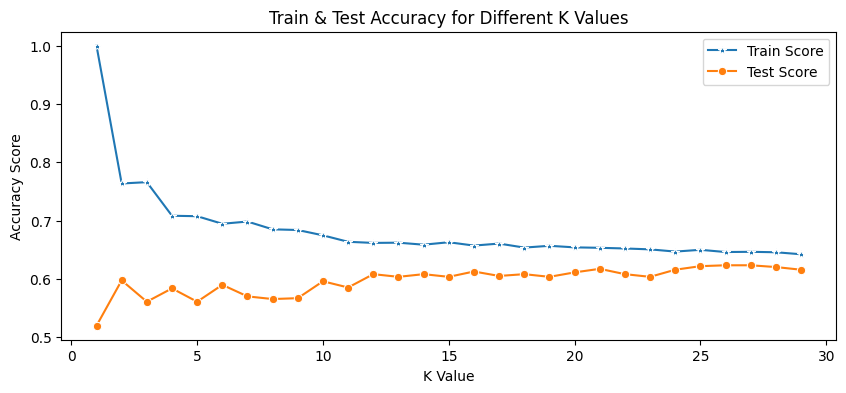

In [17]:
plt.figure(figsize=(10,4))

sns.lineplot(x=range(1, 30), y=train_scores, marker='*', label='Train Score')
sns.lineplot(x=range(1, 30), y=test_scores, marker='o', label='Test Score')

plt.xlabel("K Value")
plt.ylabel("Accuracy Score")
plt.title("Train & Test Accuracy for Different K Values")
plt.legend()
plt.show()


After experimenting with different values of `n_neighbors` and `num_dimensions`, I found that:

* When K ranges from 1 to 30, the model's accuracy fluctuates between 61% and 65%.

* The highest accuracy (65.70% at K = 20) was achieved when `num_dimensions = 9`. However, since this is identical to the original feature count, it suggests that PCA was not an effective strategy for improving accuracy. 

Additionally, I experimented with reducing the dataset's dimensions to 2 and, using a function I learned in lectures, visualized the optimal `decision boundary` under this setting.

In [18]:
def plot_decision(X, y, model, n_classes=2):
   
    min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
    min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1
    x1grid, x2grid = np.meshgrid(np.arange(min1, max1, 0.1),
                                  np.arange(min2, max2, 0.1))

    grid_points = np.c_[x1grid.ravel(), x2grid.ravel()]
    yhat = model.predict(grid_points)
    zz = yhat.reshape(x1grid.shape)

    plt.contourf(x1grid, x2grid, zz, cmap=plt.cm.Paired, alpha=0.5)

    for class_value in range(n_classes):
        row_ix = np.where(y == class_value)
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=f'Class {class_value}')

    plt.legend()
    plt.show()

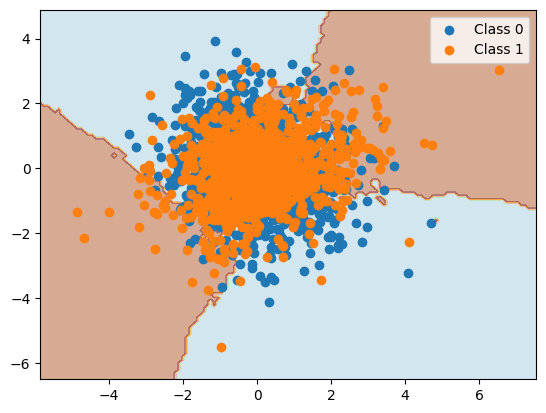

In [19]:
knn = KNeighborsClassifier(n_neighbors = 26)
knn.fit(x_train,y_train)

plot_decision(x_train, y_train, knn)

From the plot, it is visually evident that the model's classification performance is suboptimal.

Given this observation, I began exploring alternative approaches beyond PCA to improve the model's accuracy.

After further study, I learned that `GridSearchCV` could potentially help optimize the best parameter for the model.

GridSearchCV is a hyperparameter tuning method provided by Scikit-Learn. It performs an exhaustive grid search over all specified parameter combinations, evaluates their performance, and identifies the optimal configuration.

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state = 0,stratify=y)

In [21]:
# Apply GridSearchCV to optomize parameters
parameters = {'n_neighbors': range(1, 31)}
  
# defining parameter range
grid_kn = GridSearchCV(estimator = knn, # Model
                       param_grid = parameters, # Range of K
                       scoring='accuracy',  # Evaluation on test set
                       cv=5, # Cross Validation
                       verbose = 1, # Time to calculate
                       n_jobs = -1,
                       return_train_score=True,
                       ) # Help to CPU  ====> For big dataset
  
# fitting the model for grid search
grid_kn.fit(x_train, y_train.ravel())


C:\Users\lenovo\AppData\Local\Temp\ipykernel_35700\3027757008.py:15: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_kn.fit(x_train, y_train.ravel())


Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=26), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 31)}, return_train_score=True,
             scoring='accuracy', verbose=1)

In [22]:
grid_kn.best_params_

{'n_neighbors': 29}

Within the specified range, the optimal K value determined by GridSearchCV is 29

In [23]:
grid_kn.best_score_

np.float64(0.6511450381679389)

The best model accuracy achieved was approximately 65.11%.

In practice, GridSearchCV did not significantly improve the model's accuracy

In [24]:
# Saved the best model found by GridSearchCV.

grid_kn_1 = grid_kn.best_estimator_

Similarly, I also plotted the train_scores and test scores of Griedsearch for different K values.

In [25]:
cv_results = pd.DataFrame(grid_kn.cv_results_)

train_scores = cv_results["mean_train_score"]  
test_scores = cv_results["mean_test_score"]    
k_values = cv_results["param_n_neighbors"]     

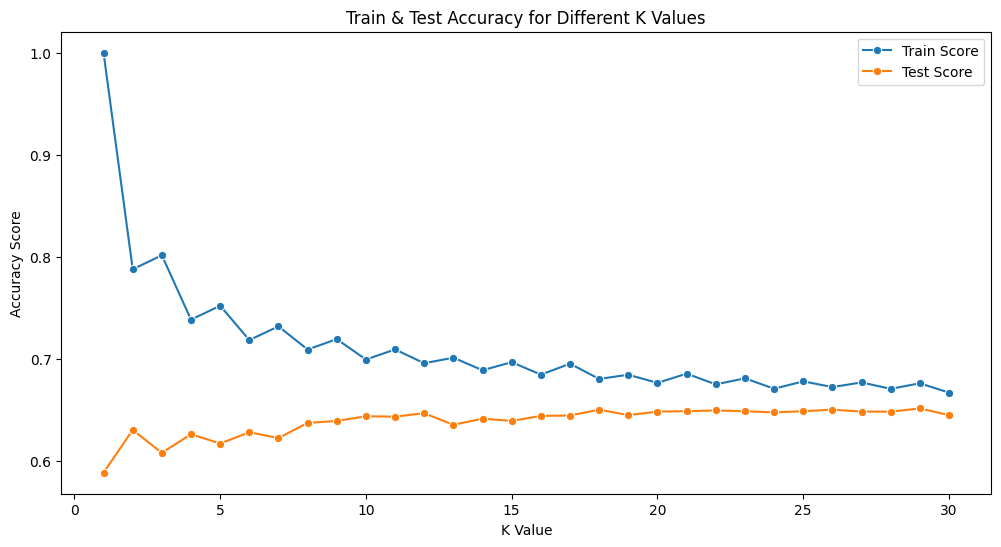

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=k_values, y=train_scores, marker="o", label="Train Score")
sns.lineplot(x=k_values, y=test_scores, marker="o", label="Test Score")

plt.xlabel("K Value")
plt.ylabel("Accuracy Score")
plt.title("Train & Test Accuracy for Different K Values")
plt.legend()
plt.show()

After the process of model training, I need to evaluate the performance of the model。

A `confusion matrix` is used evaluate the performance of classification models.

It helps to assess how well the algorithm can classify data into the correct categories.

Next, I will plot the it and conduct a analysis.

In [27]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

y_pred = grid_kn_1.predict(x_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,365,35,400
1,199,57,256
All,564,92,656


Text(0.5, 23.52222222222222, 'Predicted label')

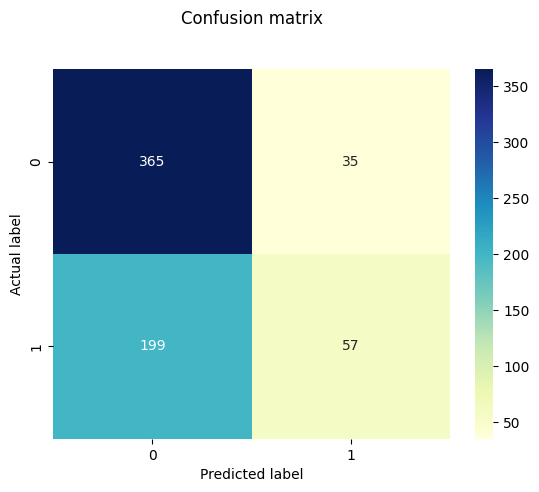

In [28]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

True Negative (TN) = 365
False Positive (FP) = 35
False Negative (FN) = 199
True Positive (TP) = 57

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76       400
           1       0.62      0.22      0.33       256

    accuracy                           0.64       656
   macro avg       0.63      0.57      0.54       656
weighted avg       0.64      0.64      0.59       656



Upon analysis, I found that:

* While the model's overall accuracy is around 64%, the `recall` and `F1-score` for the `positive` class (potable water) are notably low. This may be influenced by the original dataset, which contains more negative class than the positive ones.

* This suggests that the model struggles to correctly identify potable water samples, leading to poor classification performance for the positive class.

## Conclusion

In this week's project, I attempted to train a KNN model for water quality prediction. Throughout this process, I expanded my data processing techniques, such as mean imputation, and I optimized the performance of the KNN model using PCA and GridSearchCV by finding the optimal dimensionality reduction parameters and the best K value.

However, not all aspects of the project progressed smoothly. Despite experimenting with multiple approaches, the model's accuracy remained relatively low, which became a key challenge. Recognizing this issue, I actively sought solutions. After discovering that LightGBM can be integrated with KNN, I studied the relevant algorithms and attempted to implement them in this project.

In [30]:
# random_state = 42

# param_test = {
#     'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
#     'n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
#     'num_leaves': sp_randint(6, 50), 
#     'min_child_samples': sp_randint(100, 500), 
#     'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#     'subsample': sp_uniform(loc=0.2, scale=0.8), 
#     'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
#     'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#     'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#     'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
# }

# # number of combinations
# n_iter = 300

# # intialize lgbm and lunch the search
# lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, metric='None', n_jobs=4)

# grid_search = RandomizedSearchCV(
#     estimator=lgbm_clf,
#     param_distributions=param_test, 
#     n_iter=n_iter,
#     scoring='accuracy',
#     cv=5,  # 5 
#     refit=True,
#     random_state=random_state,
#     verbose=True
# )

# grid_search.fit(x, y)  

# opt_parameters = grid_search.best_params_

# lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)
# lgbm_clf.fit(
#     x, y,
#     early_stopping_rounds=100,   
#     eval_metric="auc",
#     eval_set=[(x, y)],
#     eval_names=["valid"],
#     verbose=0,
#     categorical_feature="auto"
# )


# print("best parameters: ", opt_parameters)

However, my laptop took an excessive amount of time to run this algorithm and frequently crashed. This was likely due to improper parameter settings, such as an excessively high number of training iterations.

Additionally, when visualizing the decision boundary, I reduced the dataset's features to two dimensions to generate a 2D plot. However, this approach is not applicable when the number of features exceeds two, limiting the model’s visual interpretability. Finally, the model performed poorly on the positive class, significantly affecting the fairness of predictions, which is another critical issue to address.

These challenges have become my future targets. I plan to continue studying LightGBM, which is widely used across many projects and demonstrates strong performance. Mastering its algorithms will likely benefit my future machine learning tasks.

Visualization is another area I aim to explore further—2D plots are not always suitable for higher-dimensional data analysis. To handle multi-dimensional features, I need to learn new visualization techniques.

Lastly, I will experiment with resampling the original dataset or adjusting class weights to mitigate the model’s failure in predicting positive cases and improve its overall fairness.